In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110856 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
--2019-02-05 08:47:34--  https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
Resolving launchpad.net (launchpad.net)... 91.189.89.223, 91.189.89.222, 2001:67c:1560:8003::8003, ...
Connecting to launchpad.net (launchpad.net)|91.189.89.223|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2019-02-05 08:47:34 ERROR 404: Not Found.

dpkg: error: cannot access archive 'google-drive-ocaml

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer

In [0]:
def load_data(fold_path):
  data = load_files(fold_path)
  files = np.array(data['filenames'])
  targ = np.array(data['target'])
  one_hot = LabelBinarizer()
  ohd = one_hot.fit_transform(targ)
  return files,ohd

In [0]:
def ext_im(im_file):
  img = cv2.imread(im_file)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256,256))
  img = img/255
  return img

In [0]:
def ext_im_gr(im_file):
  img = cv2.imread(im_file)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(256,256))
  img = np.expand_dims(img,axis=2)
  img = img/255
  return img

In [0]:
def tensor_4d(fil):
  lis = [ext_im(im) for im in tqdm(fil)]
  return np.stack(lis,axis=0)

In [0]:
def tensor_4d_gr(fil):
  lis = [ext_im_gr(im) for im in tqdm(fil)]
  return np.stack(lis,axis=0)

In [0]:
def get_filter(shape,na):
  with tf.variable_scope('unet'+na,reuse=tf.AUTO_REUSE):
    w = tf.get_variable(name=na,shape=shape,dtype='float32',initializer=tf.random_normal_initializer(dtype='float32',mean=0.0,stddev=1.0))
  return w

In [0]:
def dice_cof(inp_img,pred_img):
  inp = tf.reshape(inp_img,shape=[-1])
  pred = tf.reshape(pred_img,shape=[-1])
  smooth = 1.0
  intersection = tf.reduce_sum(inp*pred)
  score = (2.* intersection + smooth)/(tf.reduce_sum(inp) + tf.reduce_sum(pred)+smooth)
  return score
  

In [0]:
def dice_loss(inp,pred):
  loss = (1 - dice_cof(inp,pred))
  return loss

In [0]:
img_fold = 'drive/datasets/ISBI/images'
lab_fold = 'drive/datasets/ISBI/labels'
tes_img_fold = 'drive/datasets/ISBI/test/images'
tes_lab_fold = 'drive/datasets/ISBI/test/labels'

In [0]:
img_files,_ = load_data(img_fold)

In [0]:
lab_files,_ = load_data(lab_fold)

In [0]:
tes_img_files,_ = load_data(tes_img_fold)

In [0]:
tes_lab_files,_ = load_data(tes_lab_fold)

In [0]:
imgs = tensor_4d(img_files)
tes_imgs = tensor_4d(tes_img_files)
labs = tensor_4d_gr(lab_files)
tes_labs = tensor_4d_gr(tes_lab_files)

100%|██████████| 30/30 [00:00<00:00, 224.01it/s]


In [0]:
def unet(inp):
  #f1 = get_filter(shape=[3,3,3,16])
  lay_16_1 = tf.nn.conv2d(inp,filter=get_filter(shape=[3,3,3,16],na='w_1'),strides=[1,1,1,1],padding='SAME',name='conv_16_1')
  lay_16_2 = tf.nn.relu(lay_16_1,name='re_16_1')
  m1,v1 = tf.nn.moments(lay_16_2,axes=[0,1,2])
  lay_16_3 = tf.nn.batch_normalization(lay_16_2,mean=m1,variance=v1,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_16')
  lay_16_4 = tf.nn.conv2d(lay_16_3,filter=get_filter([3,3,16,16],na='w_2'),strides=[1,1,1,1],padding='SAME',name='conv_16_2')
  lay_16_5 = tf.nn.relu(lay_16_4,name='re_16_2')
  lay_p1 = tf.nn.max_pool(lay_16_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_1')
  
  lay_32_1 = tf.nn.conv2d(lay_p1,filter=get_filter([3,3,16,32],na='w_3'),strides=[1,1,1,1],padding='SAME',name='conv_32_1')
  lay_32_2 = tf.nn.relu(lay_32_1,name='re_32_1')
  m2,v2 = tf.nn.moments(lay_32_2,axes=[0,1,2])
  lay_32_3 = tf.nn.batch_normalization(lay_32_2,mean=m2,variance=v2,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_32')
  lay_32_4 = tf.nn.conv2d(lay_32_3,filter=get_filter([3,3,32,32],na='w_4'),strides=[1,1,1,1],padding='SAME',name='conv_32_2')
  lay_32_5 = tf.nn.relu(lay_32_4,name='re_32_2')
  lay_p2 = tf.nn.max_pool(lay_32_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_2')
  
  lay_64_1 = tf.nn.conv2d(lay_p2,filter=get_filter([3,3,32,64],na='w_5'),strides=[1,1,1,1],padding='SAME',name='conv_64_1')
  lay_64_2 = tf.nn.relu(lay_64_1,name='re_64_1')
  m3,v3 = tf.nn.moments(lay_64_2,axes=[0,1,2])
  lay_64_3 = tf.nn.batch_normalization(lay_64_2,mean=m3,variance=v3,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_64')
  lay_64_4 = tf.nn.conv2d(lay_64_3,filter=get_filter([3,3,64,64],na='w_6'),strides=[1,1,1,1],padding='SAME',name='conv_64_2')
  lay_64_5 = tf.nn.relu(lay_64_4,name='re_64_2')
  lay_p3 = tf.nn.max_pool(lay_64_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_3')
  
  lay_128_1 = tf.nn.conv2d(lay_p3,filter=get_filter([3,3,64,128],na='w_7'),strides=[1,1,1,1],padding='SAME',name='conv_128_1')
  lay_128_2 = tf.nn.relu(lay_128_1,name='re_128_1')
  m4,v4 = tf.nn.moments(lay_128_2,axes=[0,1,2])
  lay_128_3 = tf.nn.batch_normalization(lay_128_2,mean=m4,variance=v4,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_128')
  lay_128_4 = tf.nn.conv2d(lay_128_3,filter=get_filter([3,3,128,128],na='w_8'),strides=[1,1,1,1],padding='SAME',name='conv_128_2')
  lay_128_5 = tf.nn.relu(lay_128_4,name='re_128_2')
  lay_p4 = tf.nn.max_pool(lay_128_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_4')
  
  lay_256_1 = tf.nn.conv2d(lay_p4,filter=get_filter([3,3,128,256],na='w_9'),strides=[1,1,1,1],padding='SAME',name='conv_256_1')
  lay_256_2 = tf.nn.relu(lay_256_1,name='re_256_1')
  m5,v5 = tf.nn.moments(lay_256_2,axes=[0,1,2])
  lay_256_3 = tf.nn.batch_normalization(lay_256_2,mean=m5,variance=v5,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_256')
  lay_256_4 = tf.nn.conv2d(lay_256_3,filter=get_filter([3,3,256,256],na='w_10'),strides=[1,1,1,1],padding='SAME',name='conv_256_2')
  lay_256_5 = tf.nn.relu(lay_256_4,name='re_256_2')
  lay_p5 = tf.nn.max_pool(lay_256_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_5')
  
  lay_512_1 = tf.nn.conv2d(lay_p5,filter=get_filter([3,3,256,512],na='w_11'),strides=[1,1,1,1],padding='SAME',name='conv_512_1')
  lay_512_2 = tf.nn.relu(lay_512_1,name='re_512_1')
  m6,v6 = tf.nn.moments(lay_512_2,axes=[0,1,2])
  lay_512_3 = tf.nn.batch_normalization(lay_512_2,mean=m6,variance=v6,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_512')
  lay_512_4 = tf.nn.conv2d(lay_512_3,filter=get_filter([3,3,512,512],na='w_12'),strides=[1,1,1,1],padding='SAME',name='conv_512_2')
  lay_512_5 = tf.nn.relu(lay_512_4,name='re_512_2')
  lay_p6 = tf.nn.max_pool(lay_512_5,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='pool_6')
  
  lay_1024_1 = tf.nn.conv2d(lay_p6,filter=get_filter([3,3,512,1024],na='w_13'),strides=[1,1,1,1],padding='SAME',name='conv_1024_1')
  lay_1024_2 = tf.nn.relu(lay_1024_1,name='re_1024_1')
  m7,v7 = tf.nn.moments(lay_1024_2,axes=[0,1,2])
  lay_1024_3 = tf.nn.batch_normalization(lay_1024_2,mean=m7,variance=v7,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='bn_1024')
  lay_1024_4 = tf.nn.conv2d(lay_1024_3,filter=get_filter([3,3,1024,1024],na='w_14'),strides=[1,1,1,1],padding='SAME',name='conv_1024_2')
  lay_1024_5 = tf.nn.relu(lay_1024_4,name='re_1024_2')
  #lay_p7 = tf.nn.max_pool(lay_1024,ksize=[1,2,2,1],strides=[1,1,1,1],padding='SAME',name='pool_7')
  
  up_512 = tf.image.resize_images(images=lay_1024_5,size=[8,8],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_512_1 = tf.nn.conv2d(up_512,filter=get_filter([3,3,1024,512],na='w_15'),strides=[1,1,1,1],padding='SAME',name='mer_512_1')
  con_512_2 = tf.nn.relu(con_512_1,name='rel_512_1')
  mer_512 = tf.concat([lay_512_5,con_512_2],axis=-1,name='mer_512_2')
  con_512_3 = tf.nn.conv2d(mer_512,filter=get_filter([3,3,1024,512],na='w_16'),strides=[1,1,1,1],padding='SAME',name='mer_512_3')
  con_512_4 = tf.nn.relu(con_512_3,name='rel_512_2')
  m8,v8 = tf.nn.moments(con_512_4,axes=[0,1,2])
  con_512_5 = tf.nn.batch_normalization(con_512_4,mean=m8,variance=v8,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_512')
  con_512_6 = tf.nn.conv2d(con_512_5,filter=get_filter([3,3,512,512],na='w_17'),strides=[1,1,1,1],padding='SAME',name='mer_512_4')
  con_512_7 = tf.nn.relu(con_512_6,name='rel_512_3')
  
  up_256 = tf.image.resize_images(images=con_512_7,size=[16,16],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_256_1 = tf.nn.conv2d(up_256,filter=get_filter([3,3,512,256],na='w_18'),strides=[1,1,1,1],padding='SAME',name='mer_256_1')
  con_256_2 = tf.nn.relu(con_256_1,name='rel_256_1')
  mer_256 = tf.concat([lay_256_5,con_256_2],axis=-1,name='mer_256_2')
  con_256_3 = tf.nn.conv2d(mer_256,filter=get_filter([3,3,512,256],na='w_19'),strides=[1,1,1,1],padding='SAME',name='mer_256_3')
  con_256_4 = tf.nn.relu(con_256_3,name='rel_256_2')
  m9,v9 = tf.nn.moments(con_256_4,axes=[0,1,2])
  con_256_5 = tf.nn.batch_normalization(con_256_4,mean=m9,variance=v9,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_256')
  con_256_6 = tf.nn.conv2d(con_256_5,filter=get_filter([3,3,256,256],na='w_20'),strides=[1,1,1,1],padding='SAME',name='mer_256_4')
  con_256_7 = tf.nn.relu(con_256_6,name='rel_256_3')
  
  up_128 = tf.image.resize_images(images=con_256_7,size=[32,32],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_128_1 = tf.nn.conv2d(up_128,filter=get_filter([3,3,256,128],na='w_21'),strides=[1,1,1,1],padding='SAME',name='mer_128_1')
  con_128_2 = tf.nn.relu(con_128_1,name='rel_128_1')
  mer_128 = tf.concat([lay_128_5,con_128_2],axis=-1,name='mer_128_2')
  con_128_3 = tf.nn.conv2d(mer_128,filter=get_filter([3,3,256,128],na='w_22'),strides=[1,1,1,1],padding='SAME',name='mer_128_3')
  con_128_4 = tf.nn.relu(con_128_3,name='rel_128_2')
  m10,v10 = tf.nn.moments(con_128_4,axes=[0,1,2])
  con_128_5 = tf.nn.batch_normalization(con_128_4,mean=m10,variance=v10,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_128')
  con_128_6 = tf.nn.conv2d(con_128_5,filter=get_filter([3,3,128,128],na='w_23'),strides=[1,1,1,1],padding='SAME',name='mer_128_4')
  con_128_7 = tf.nn.relu(con_128_6,name='rel_128_3')
  
  up_64 = tf.image.resize_images(images=con_128_7,size=[64,64],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_64_1 = tf.nn.conv2d(up_64,filter=get_filter([3,3,128,64],na='w_24'),strides=[1,1,1,1],padding='SAME',name='mer_64_1')
  con_64_2 = tf.nn.relu(con_64_1,name='rel_64_1')
  mer_64 = tf.concat([lay_64_5,con_64_2],axis=-1,name='mer_64_2')
  con_64_3 = tf.nn.conv2d(mer_64,filter=get_filter([3,3,128,64],na='w_25'),strides=[1,1,1,1],padding='SAME',name='mer_64_3')
  con_64_4 = tf.nn.relu(con_64_3,name='rel_64_2')
  m11,v11 = tf.nn.moments(con_64_4,axes=[0,1,2])
  con_64_5 = tf.nn.batch_normalization(con_64_4,mean=m11,variance=v11,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_64')
  con_64_6 = tf.nn.conv2d(con_64_5,filter=get_filter([3,3,64,64],na='w_26'),strides=[1,1,1,1],padding='SAME',name='mer_64_4')
  con_64_7 = tf.nn.relu(con_64_6,name='rel_64_3')
  
  up_32 = tf.image.resize_images(images=con_64_7,size=[128,128],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_32_1 = tf.nn.conv2d(up_32,filter=get_filter([3,3,64,32],na='w_27'),strides=[1,1,1,1],padding='SAME',name='mer_32_1')
  con_32_2 = tf.nn.relu(con_32_1,name='rel_32_1')
  mer_32 = tf.concat([lay_32_5,con_32_2],axis=-1,name='mer_32_2')
  con_32_3 = tf.nn.conv2d(mer_32,filter=get_filter([3,3,64,32],na='w_28'),strides=[1,1,1,1],padding='SAME',name='mer_32_3')
  con_32_4 = tf.nn.relu(con_32_3,name='rel_32_2')
  m12,v12 = tf.nn.moments(con_32_4,axes=[0,1,2])
  con_32_5 = tf.nn.batch_normalization(con_32_4,mean=m12,variance=v12,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_32')
  con_32_6 = tf.nn.conv2d(con_32_5,filter=get_filter([3,3,32,32],na='w_29'),strides=[1,1,1,1],padding='SAME',name='mer_32_4')
  con_32_7 = tf.nn.relu(con_32_6,name='rel_32_3')
  
  up_16 = tf.image.resize_images(images=con_32_7,size=[256,256],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  con_16_1 = tf.nn.conv2d(up_16,filter=get_filter([3,3,32,16],na='w_30'),strides=[1,1,1,1],padding='SAME',name='mer_16_1')
  con_16_2 = tf.nn.relu(con_16_1,name='rel_16_1')
  mer_16 = tf.concat([lay_16_5,con_16_2],axis=-1,name='mer_16_2')
  con_16_3 = tf.nn.conv2d(mer_16,filter=get_filter([3,3,32,16],na='w_31'),strides=[1,1,1,1],padding='SAME',name='mer_16_3')
  con_16_4 = tf.nn.relu(con_16_3,name='rel_16_2')
  m13,v13 = tf.nn.moments(con_16_4,axes=[0,1,2])
  con_16_5 = tf.nn.batch_normalization(con_16_4,mean=m13,variance=v13,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='mer_bn_16')
  con_16_6 = tf.nn.conv2d(con_16_5,filter=get_filter([3,3,16,16],na='w_32'),strides=[1,1,1,1],padding='SAME',name='mer_16_4')
  con_16_7 = tf.nn.relu(con_16_6,name='rel_16_3')
  
  fin_img = tf.nn.conv2d(con_16_7,filter=get_filter([1,1,16,1],na='w_33'),strides=[1,1,1,1],padding='SAME',name='final_image')
  #m8,v8 = tf.nn.moments(con_512_4,axes=[0,1,2])
  #fin = tf.nn.batch_normalization(fin_img,mean=m1,variance=v1,offset=0.0,scale=1.0,variance_epsilon=0.0003,name='fin_bn_16')
  #fin_img = tf.nn.sigmoid(fin_img)
  return fin_img

In [0]:
ip = tf.placeholder(shape=[None,256,256,3],dtype='float32',name='input_img')
op = tf.placeholder(shape=[None,256,256,1],dtype='float32',name='output_img')

In [0]:
mod = unet(ip)
fin_out = tf.nn.sigmoid(mod)
#los,los_op = tf.metrics.mean_iou(labels=op,predictions=mod,num_classes=1)
los = tf.nn.sigmoid_cross_entropy_with_logits(logits=mod,labels=op)
los_bce = tf.reduce_mean(los)
los_dice = tf.reduce_mean(dice_loss(op,fin_out))
los_m = tf.log(los_dice)
#los_m = tf.reduce_mean(op * (-tf.log(mod)) + (1 - op) * (-tf.log(1 - mod)),axis=1)
#los = tf.reduce_mean(tf.square(mod-op))
opt = tf.train.AdamOptimizer(learning_rate=0.001)
train = opt.minimize(los_m)
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
with tf.Session() as sess:
  sess.run(init)
  for epoch in range(800):
    for start,end in zip(range(0,len(imgs),3),range(3,len(imgs),3)):
      xtr = imgs[start:end]
      ytr = labs[start:end]
      #print(xtr.shape)
      #x = sess.run(mod,feed_dict={ip:xtr})
      #print((los.shape))
      sess.run(train,feed_dict={ip:xtr,op:ytr})
      lo = sess.run(los_m,feed_dict={ip:xtr,op:ytr})
      print('epoch:',epoch,'loss:',lo)
    val_loss = sess.run(los_m,feed_dict={ip:tes_imgs,op:tes_labs})
    print('epoch:',epoch,'val loss:',val_loss)

epoch: 0 loss: -1.2175182
epoch: 0 loss: -1.2418898
epoch: 0 loss: -1.2670994
epoch: 0 loss: -1.3327332
epoch: 0 loss: -1.3174915
epoch: 0 loss: -1.3302093
epoch: 0 loss: -1.369434
epoch: 0 loss: -1.3780782
epoch: 0 loss: -1.3446652
epoch: 0 val loss: -1.3996649
epoch: 1 loss: -1.3762399
epoch: 1 loss: -1.4043536
epoch: 1 loss: -1.4566932
epoch: 1 loss: -1.5148168
epoch: 1 loss: -1.4829755
epoch: 1 loss: -1.4888977
epoch: 1 loss: -1.5251647
epoch: 1 loss: -1.5662334
epoch: 1 loss: -1.514774
epoch: 1 val loss: -1.5793973
epoch: 2 loss: -1.5898337
epoch: 2 loss: -1.5844916
epoch: 2 loss: -1.6538596
epoch: 2 loss: -1.7249267
epoch: 2 loss: -1.6568922
epoch: 2 loss: -1.6800091
epoch: 2 loss: -1.7421623
epoch: 2 loss: -1.752702
epoch: 2 loss: -1.6899606
epoch: 2 val loss: -1.7674206
epoch: 3 loss: -1.7403742
epoch: 3 loss: -1.7362552
epoch: 3 loss: -1.843266
epoch: 3 loss: -1.9410815
epoch: 3 loss: -1.8614864
epoch: 3 loss: -1.8648658
epoch: 3 loss: -1.9198998
epoch: 3 loss: -1.9354013
epoc

In [0]:
labs[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

0  1


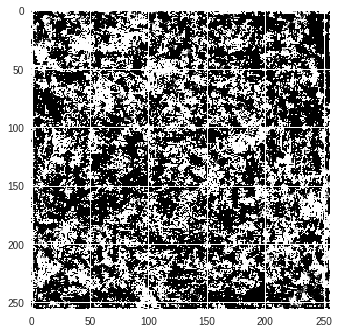

(1, 256, 256, 1)
1  2


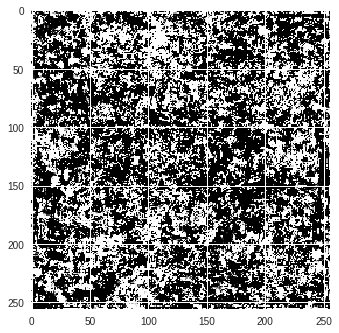

(1, 256, 256, 1)
2  3


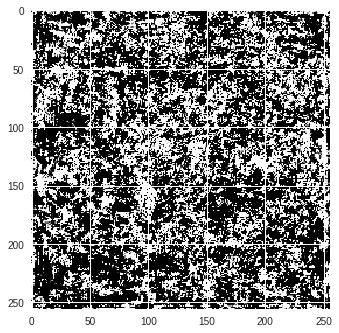

(1, 256, 256, 1)
3  4


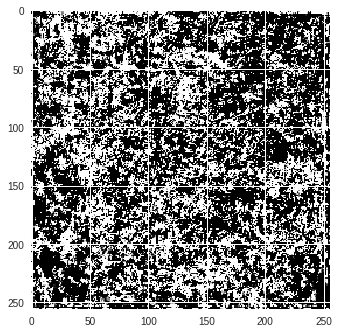

(1, 256, 256, 1)
4  5


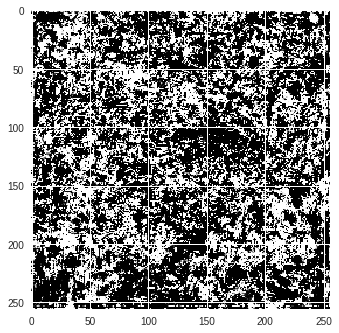

(1, 256, 256, 1)
5  6


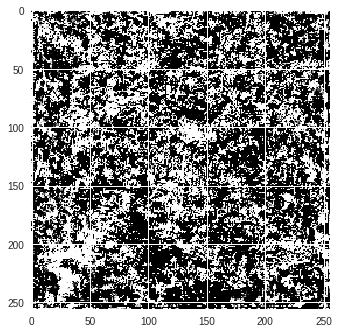

(1, 256, 256, 1)
6  7


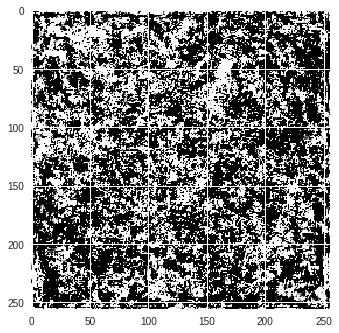

(1, 256, 256, 1)
7  8


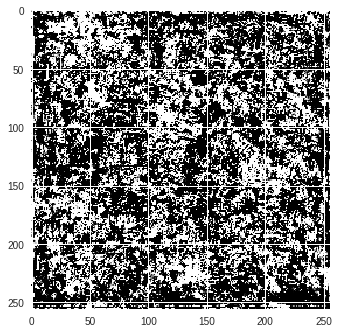

(1, 256, 256, 1)
8  9


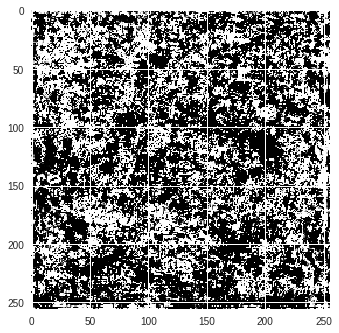

(1, 256, 256, 1)
9  10


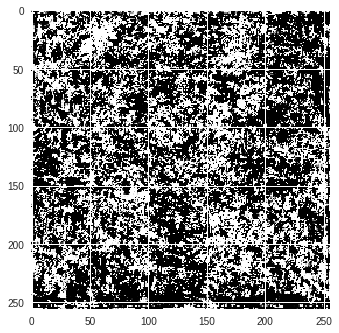

(1, 256, 256, 1)
10  11


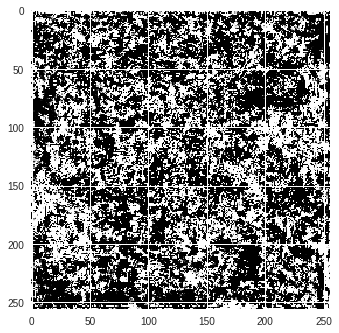

(1, 256, 256, 1)
11  12


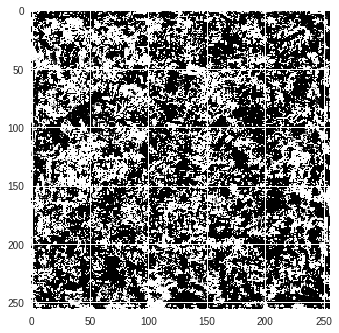

(1, 256, 256, 1)
12  13


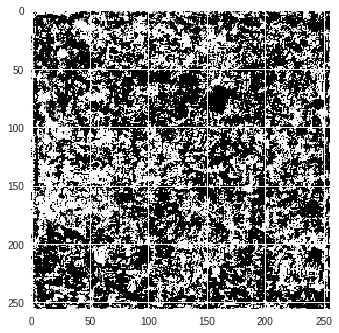

(1, 256, 256, 1)
13  14


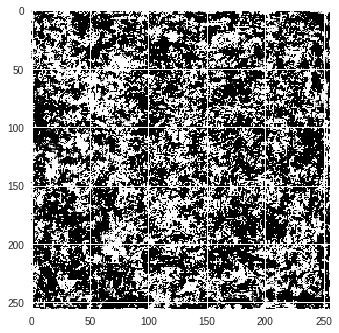

(1, 256, 256, 1)
14  15


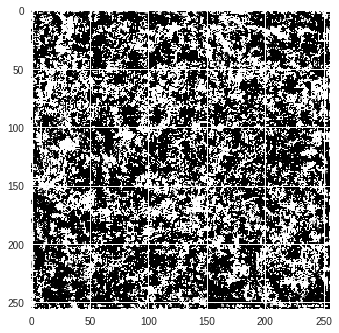

(1, 256, 256, 1)
15  16


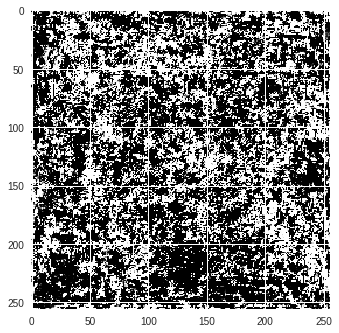

(1, 256, 256, 1)
16  17


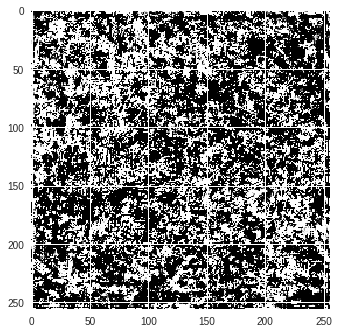

(1, 256, 256, 1)
17  18


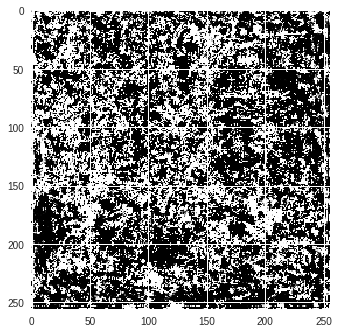

(1, 256, 256, 1)
18  19


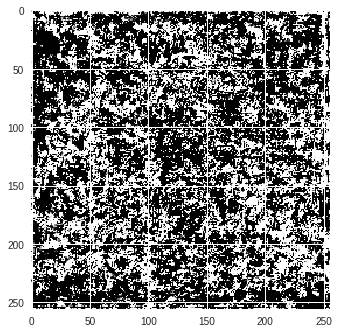

(1, 256, 256, 1)
19  20


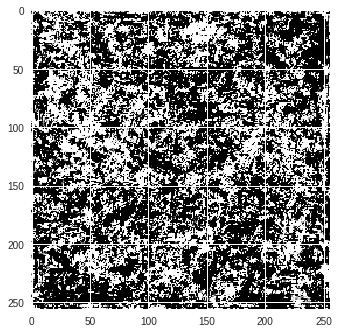

(1, 256, 256, 1)
20  21


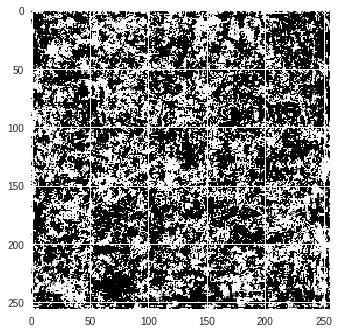

(1, 256, 256, 1)
21  22


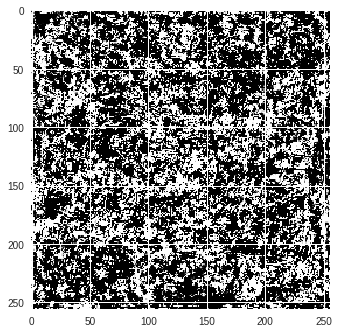

(1, 256, 256, 1)
22  23


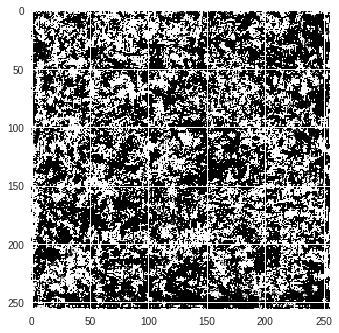

(1, 256, 256, 1)
23  24


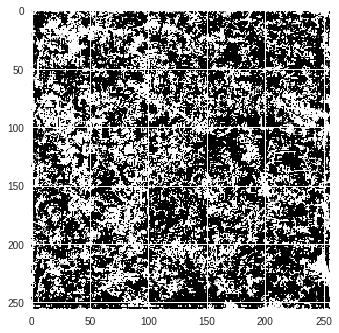

(1, 256, 256, 1)
24  25


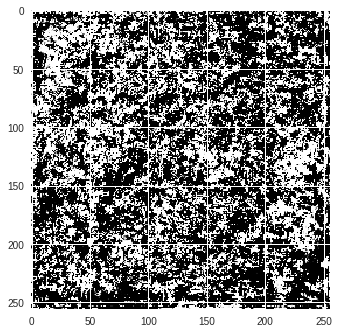

(1, 256, 256, 1)
25  26


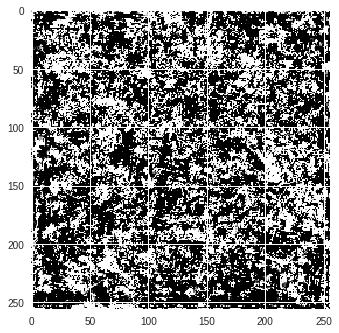

(1, 256, 256, 1)
26  27


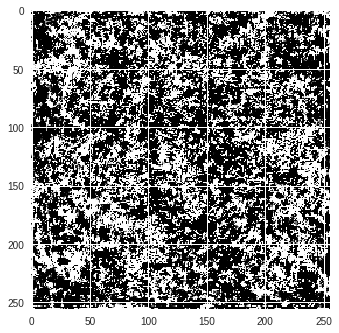

(1, 256, 256, 1)
27  28


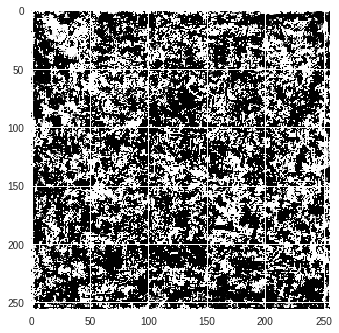

(1, 256, 256, 1)
28  29


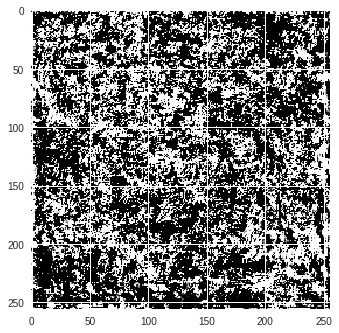

(1, 256, 256, 1)


In [0]:
with tf.Session() as sess:
  sess.run(init)
  for epoch in range(1):
    for start,end in zip(range(0,len(imgs),1),range(1,len(imgs),1)):
      xtr = imgs[start:end]
      ytr = labs[start:end]
      print(start,'', end)
      x = sess.run((tf.nn.sigmoid(mod)),feed_dict={ip:xtr})
      plt.imshow(x[0,:,:,0],cmap='gray')
      plt.show()
      print(x.shape)